# Things to look at
* proportion of validators with effective balance below 32 ETH
* distribution of validator incomes
* comparison of average validator reward with the expected case from the model
* per-validator breakdown explaining why they fell short of the maximum possible (missed attestations, missed proposals, incorrect target/head, delayed inclusion)
* per-validator stats (longest outage, longest streak, uptime, proposal opportunities (how lucky?), proportion of successful proposals, inclusion delays (delay due to missed block versus not included in block - how lucky?)

In [13]:
# imports
import time

import psycopg2
import matplotlib.pyplot as plt
import pandas as pd

In [10]:
# open/restart connection to chaind database
try:
    cursor.close()
    connection.close()
except:
    pass

connection = psycopg2.connect(user="chain", host="127.0.0.1", database="chain", password="medalla")
cursor = connection.cursor()

In [3]:
# basic info about the dataset
cursor.execute("SELECT MAX(f_slot) FROM t_blocks")
latest_slot = cursor.fetchone()[0]
n_slots = latest_slot + 1
n_epochs = (n_slots - (n_slots % 32)) // 32
print(f"latest slot: {latest_slot}, latest complete epoch: {n_epochs - 1}")

cursor.execute("SELECT f_slot, f_root FROM t_blocks ORDER BY f_slot DESC LIMIT 1")
latest_block = cursor.fetchone()
slot, root = latest_block[0], latest_block[1].hex()
print(f"latest block root: {root}")

latest slot: 936432, latest complete epoch: 29262
latest block root: e97d41f3761a047fdeda4b9803210bfe3cb451a064b141f79ac76655f2c28c36


In [11]:
# get info about dataset and validators

cursor.execute("SELECT MAX(f_slot) FROM t_blocks")
latest_slot = cursor.fetchone()[0]
n_slots = latest_slot + 1
n_epochs = (n_slots - (n_slots % 32)) // 32

cursor.execute("SELECT f_activation_eligibility_epoch, f_activation_epoch, f_exit_epoch, f_slashed "
               "FROM t_validators ORDER BY f_index")
result = cursor.fetchall()
validators = [{"activation_eligibility_epoch": r[0],
               "activation_epoch"            : r[1],
               "exit_epoch"                  : r[2],
               "slashed"                     : r[3]} for r in result]

In [ ]:
# get validator status by epoch - waiting, active, exited, slashed
start_time = time.time()

waiting_count = [0] * n_epochs
active_count  = [0] * n_epochs
slashed_count = [0] * n_epochs
exited_count  = [0] * n_epochs

for epoch in range(n_epochs):
    for validator in validators:
        if epoch >= validator["activation_eligibility_epoch"] and epoch < validator["activation_epoch"]:
            waiting_count[epoch] += 1
        elif validator["exit_epoch"] != -1 and epoch >= validator["exit_epoch"] :
            if validator["slashed"]:
                slashed_count[epoch] += 1
            else:
                exited_count[epoch] += 1
        elif epoch >= validator["activation_epoch"]:
            active_count[epoch] += 1

    seconds = time.time() - start_time
    elapsed = time.strftime("%H:%M:%S",time.gmtime(seconds))
    left = time.strftime("%H:%M:%S",time.gmtime(seconds * ((n_epochs) / (epoch+1)-1)))
    percentage = 100*(epoch+1)/n_epochs
    print(f"epoch {epoch} of {n_epochs-1} ({percentage:.2f}%) / {elapsed} elapsed / {left} left", end='\r')

print(f"completed in {elapsed}" + ' ' * 50)       

status_data = pd.DataFrame({'waiting': waiting_count, 'active': active_count,
                            'exited': exited_count, 'slashed': slashed_count})

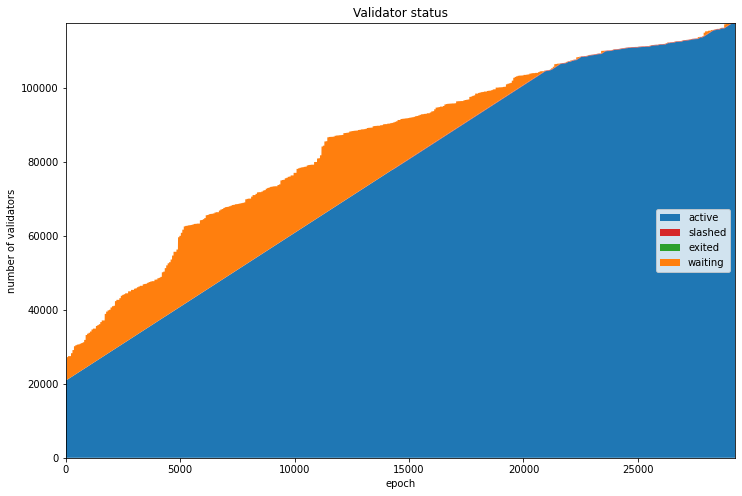

In [15]:
# draw validator status stacked area plot
fig=plt.figure(figsize=(12,8))
plt.stackplot(range(len(status_data.index)), status_data['active'], status_data['slashed'],
              status_data['exited'], status_data['waiting'],labels=['active','slashed','exited','waiting'],
              colors=['tab:blue','tab:red','tab:green','tab:orange'])
plt.legend(loc='right')
plt.margins(0,0)
plt.title('Validator status')
plt.xlabel('epoch')
plt.ylabel('number of validators')
plt.show()

In [19]:
print(status_data['slashed'].iloc[-1])
print(status_data['exited'].iloc[-1])

133
10


Minimum exited validator effective balance: 32 ETH
Non-slashed validator balance (min, max): (31, 32) ETH
Slashed validator balance (min, max): (31, 32) ETH
52 validators have an effective balance of less than 32 ETH


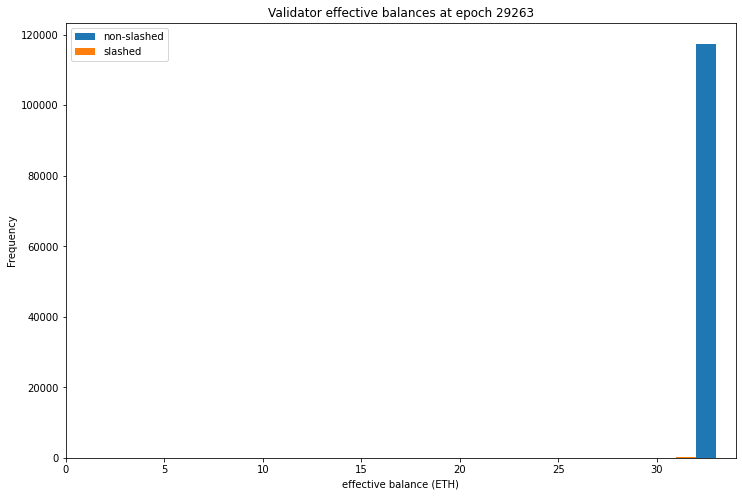

In [22]:
# show effective balances

cursor.execute(f"SELECT MIN(f_effective_balance) FROM t_validator_balances "
               f"WHERE f_validator_index IN "
               f"(SELECT f_index FROM t_validators WHERE f_exit_epoch != -1 AND NOT f_slashed)"
               f"AND f_epoch = {n_epochs-1}")

min_balance = cursor.fetchone()[0] * 10**-9
print(f"Minimum exited validator effective balance: {int(min_balance)} ETH")

cursor.execute(f"SELECT f_effective_balance FROM t_validator_balances WHERE f_validator_index IN"
               f"(SELECT f_index FROM t_validators WHERE NOT f_slashed  AND f_activation_epoch != -1)"
               f"AND f_epoch = {n_epochs-1}")
eff_balances = pd.Series([b[0]*10**-9 for b in cursor.fetchall()], name='non-slashed')

cursor.execute(f"SELECT f_effective_balance FROM t_validator_balances WHERE f_validator_index IN"
               f"(SELECT f_index FROM t_validators WHERE f_slashed)"
               f"AND f_epoch = {n_epochs-1}")
eff_balances_slashed = pd.Series([b[0]*10**-9 for b in cursor.fetchall()], name='slashed')

print(f"Non-slashed validator balance (min, max): "
      f"({int(eff_balances.min())}, {int(eff_balances.max())}) ETH")
print(f"Slashed validator balance (min, max): "
      f"({int(eff_balances_slashed.min())}, {int(eff_balances_slashed.max())}) ETH")

fig=plt.figure(figsize=(12,8))
eff_balances.plot.hist(bins=range(0,35))
eff_balances_slashed.plot.hist(bins=range(0,35))
plt.legend(loc='upper left')
plt.xlabel('effective balance (ETH)')
plt.title(f"Validator effective balances at epoch {n_epochs-1}")
plt.xlim(0,34)

cursor.execute(f"SELECT COUNT(*) FROM t_validator_balances WHERE f_validator_index IN "
               f"(SELECT f_index FROM t_validators WHERE NOT f_slashed AND f_activation_epoch != -1 "
               f"AND f_effective_balance < 32000000000) AND f_epoch = {n_epochs-1}")
n_reduced_balance = cursor.fetchone()[0]

print(f"{n_reduced_balance} validators have an effective balance of less than 32 ETH")